# Machine Learning II Individual Asignment 1

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import boxcox1p
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as metric_scorer
from scipy.stats import skew, boxcox_normmax, chi2_contingency
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

# Setting Key Values

In [2]:
SEED = 1
DATA_PATH = 'https://gist.githubusercontent.com/f-loguercio/14ac934fabcca41093a51efef335f8f2/raw/58e00b425c711ac1da2fb75f851f4fc9ce814cfa/bikesharing_daily.csv'
DATA_PATH2 = 'https://gist.githubusercontent.com/f-loguercio/f5c10c97fe9afe58f77cd102ca81719b/raw/99fb846b22abc8855de305c2159a57a77c9764cf/bikesharing_hourly.csv'
TARGET_VARIABLE = 'cnt'
SPLITS = 5
MAX_ITER = 1000
#For metric, import the required library as metric_scorer
METRIC = 'r2'

# Data Reading and Exploration
Here we read the data and print its first rows

In [3]:
def read_data(input_path):
    return pd.read_csv(input_path, parse_dates=[1])

data = read_data(DATA_PATH)
data2 = read_data(DATA_PATH2)

data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [4]:
data2.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
data.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [6]:
data2.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


We review the data types for each column

In [7]:
data.dtypes

instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

In [8]:
data2.dtypes

instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
hr                     int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

In [9]:
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data(data)

,Total,Percent
cnt,0,0.0
registered,0,0.0
casual,0,0.0
windspeed,0,0.0
hum,0,0.0
atemp,0,0.0
temp,0,0.0
weathersit,0,0.0
workingday,0,0.0
weekday,0,0.0


In [10]:
missing_data(data2)

,Total,Percent
cnt,0,0.0
weekday,0,0.0
dteday,0,0.0
season,0,0.0
yr,0,0.0
mnth,0,0.0
hr,0,0.0
holiday,0,0.0
workingday,0,0.0
registered,0,0.0


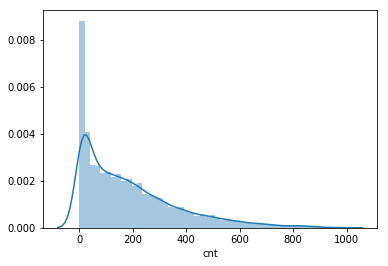

In [15]:
sns.distplot(data2['cnt'])

# Joining Daily Data to Hourly Data

In [49]:
data = pd.merge(data2, data[['dteday','weathersit','temp', 'atemp','hum', 'windspeed', 'casual','registered','cnt']], how = 'left', on = 'dteday', suffixes=('','_daily'))
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,registered,cnt,weathersit_daily,temp_daily,atemp_daily,hum_daily,windspeed_daily,casual_daily,registered_daily,cnt_daily
0,1,2011-01-01,1,0,1,0,0,6,0,1,...,13,16,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-01,1,0,1,1,0,6,0,1,...,32,40,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2,3,2011-01-01,1,0,1,2,0,6,0,1,...,27,32,2,0.344167,0.363625,0.805833,0.160446,331,654,985
3,4,2011-01-01,1,0,1,3,0,6,0,1,...,10,13,2,0.344167,0.363625,0.805833,0.160446,331,654,985
4,5,2011-01-01,1,0,1,4,0,6,0,1,...,1,1,2,0.344167,0.363625,0.805833,0.160446,331,654,985


In [50]:
def drop_columns(df, cols):
    df.drop(df[cols], axis=1, inplace = True)
    return df

data = drop_columns(data, ['instant','dteday','casual', 'casual_daily'])
data.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,...,windspeed,registered,cnt,weathersit_daily,temp_daily,atemp_daily,hum_daily,windspeed_daily,registered_daily,cnt_daily
0,1,0,1,0,0,6,0,1,0.24,0.2879,...,0.0,13,16,2,0.344167,0.363625,0.805833,0.160446,654,985
1,1,0,1,1,0,6,0,1,0.22,0.2727,...,0.0,32,40,2,0.344167,0.363625,0.805833,0.160446,654,985
2,1,0,1,2,0,6,0,1,0.22,0.2727,...,0.0,27,32,2,0.344167,0.363625,0.805833,0.160446,654,985
3,1,0,1,3,0,6,0,1,0.24,0.2879,...,0.0,10,13,2,0.344167,0.363625,0.805833,0.160446,654,985
4,1,0,1,4,0,6,0,1,0.24,0.2879,...,0.0,1,1,2,0.344167,0.363625,0.805833,0.160446,654,985


In [51]:
data.dtypes

season                int64
yr                    int64
mnth                  int64
hr                    int64
holiday               int64
weekday               int64
workingday            int64
weathersit            int64
temp                float64
atemp               float64
hum                 float64
windspeed           float64
registered            int64
cnt                   int64
weathersit_daily      int64
temp_daily          float64
atemp_daily         float64
hum_daily           float64
windspeed_daily     float64
registered_daily      int64
cnt_daily             int64
dtype: object

# Converting Columns to their true categorical type
Now fixing the data types of numerical columns that are actually categorical

In [52]:
def convert_to_category(df, cols):
    for i in cols:
        df[i] = df[i].astype('category')
    return df

data = convert_to_category(data, data.iloc[:,np.r_[0:8, 14]])

data.dtypes

season              category
yr                  category
mnth                category
hr                  category
holiday             category
weekday             category
workingday          category
weathersit          category
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
registered             int64
cnt                    int64
weathersit_daily    category
temp_daily           float64
atemp_daily          float64
hum_daily            float64
windspeed_daily      float64
registered_daily       int64
cnt_daily              int64
dtype: object

We check if any value in the dataset is NA

Now we plot pairwise relationships as well as the distribution for each column in the diagonal

In [53]:
#pairplot = sns.pairplot(data, hue=TARGET_VARIABLE, palette="husl")

# Data Imputation
Now we will impute the non valid values

In [54]:
def impute_data(df):
    return;

# Data Correlation
Now we will look at correlation, both numerical and categorical and plot them

In [55]:
def numerical_correlated(df, threshold=0.9):
    corr_matrix = np.absolute(df.select_dtypes(include=[np.number]).corr(method='spearman')).abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    return [column for column in upper.columns if any(abs(upper[column]) > threshold)], corr_matrix

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))

def categorical_correlated(df, threshold=0.9):
    columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    corr = pd.DataFrame(index=columns, columns=columns)
    for i in range(0, len(columns)):
        for j in range(i, len(columns)):
            if i == j:
                corr[columns[i]][columns[j]] = 1.0
            else:
                cell = cramers_v(df[columns[i]], df[columns[j]])
                corr[columns[i]][columns[j]] = cell
                corr[columns[j]][columns[i]] = cell
    corr.fillna(value=np.nan, inplace=True)
    upper = corr.where(
    np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    return [column for column in upper.columns if any(abs(upper[column]) > threshold)], corr


def correlated(df, threshold=0.9):
    return (categorical_correlated(df, threshold), numerical_correlated(df, threshold))

correlated_cols = correlated(data, 0.7)

if(len(correlated_cols[0][0]) + len(correlated_cols[1][0]) > 0):
    print('The following columns are correlated: ' + str(correlated_cols[0][0] + correlated_cols[1][0]))
else:
    print('No correlated columns for the selected threshold')

The following columns are correlated: ['mnth', 'workingday', 'atemp', 'cnt', 'temp_daily', 'atemp_daily', 'hum_daily', 'cnt_daily']


Plot the categorical columns

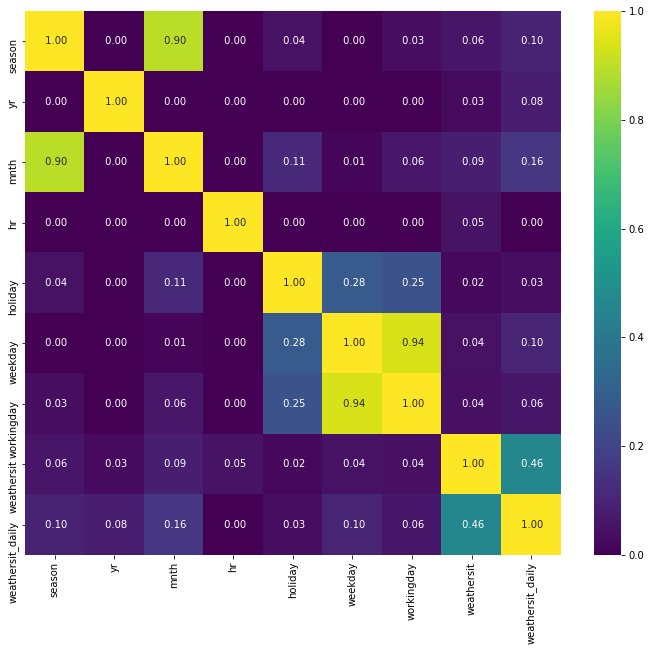

In [56]:
plt.figure(figsize=(12,10))
sns.heatmap(correlated_cols[0][1],cbar=True,fmt =' .2f', annot=True, cmap='viridis')

Plot the numerical columns

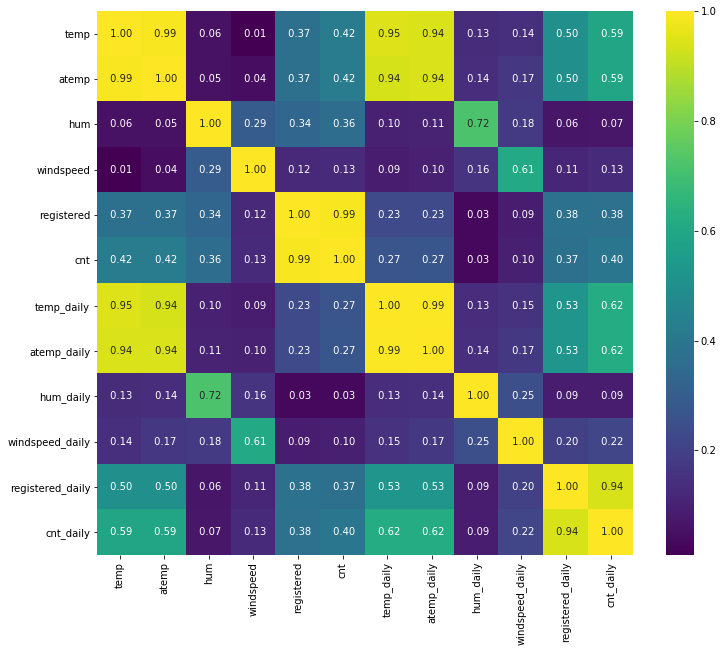

In [57]:
plt.figure(figsize=(12,10))
sns.heatmap(correlated_cols[1][1],cbar=True,fmt =' .2f', annot=True, cmap='viridis')

# Dropping Selected Correlated Columns

In [58]:
data = drop_columns(data, ['season', 'workingday', 'temp', 'temp_daily', 'atemp_daily', 'hum_daily', 'registered','registered_daily'])

In [59]:
data.head()

,yr,mnth,hr,holiday,weekday,weathersit,atemp,hum,windspeed,cnt,weathersit_daily,windspeed_daily,cnt_daily
0,0,1,0,0,6,1,0.2879,0.81,0.0,16,2,0.160446,985
1,0,1,1,0,6,1,0.2727,0.80,0.0,40,2,0.160446,985
2,0,1,2,0,6,1,0.2727,0.80,0.0,32,2,0.160446,985
3,0,1,3,0,6,1,0.2879,0.75,0.0,13,2,0.160446,985
4,0,1,4,0,6,1,0.2879,0.75,0.0,1,2,0.160446,985


# One Hot Encoding
Hot encoding categorical columns

In [60]:
def one_hot_encode(df, cols):
    initialColumns = set(df)
    
    for i in cols:
        dummies = pd.get_dummies(df[i], prefix=i, drop_first = True)
        df = pd.concat([df, dummies], axis = 1)
        df = df.drop(i, axis = 1)
    
    df = convert_to_category(df, set(df) - initialColumns)
    return df

#data = one_hot_encode(data, ['sales', 'salary'])
data.dtypes

yr                  category
mnth                category
hr                  category
holiday             category
weekday             category
weathersit          category
atemp                float64
hum                  float64
windspeed            float64
cnt                    int64
weathersit_daily    category
windspeed_daily      float64
cnt_daily              int64
dtype: object

# Data Normalization
Now we normalize the data to have a scale for all

In [61]:
def normalize_data(df, cols):
    for i in cols:
        df[i]=(df[i]-df[i].min())/(df[i].max()-df[i].min())
    return df

data = normalize_data(data, list(data.iloc[:,np.r_[:,6:10, 11:13]]))

# Fixing Data Skewness
Now we will fix skewness if present

In [62]:
def feature_skewness(df):
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric_features = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes: 
            numeric_features.append(i)
        
    feature_skew = df[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
    return feature_skew, numeric_features

def fix_skewness(df):
    feature_skew, numeric_features = feature_skewness(df)
    high_skew = feature_skew[feature_skew > 0.5]
    skew_index = high_skew.index
    
    for i in skew_index:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i]+1))

    df[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
    return df

data = fix_skewness(data)
data.head()

,yr,mnth,hr,holiday,weekday,weathersit,atemp,hum,windspeed,cnt,weathersit_daily,windspeed_daily,cnt_daily
0,0,1,0,0,6,1,0.2879,0.81,0.0,0.014911,2,0.217234,0.110792
1,0,1,1,0,6,1,0.2727,0.80,0.0,0.036985,2,0.217234,0.110792
2,0,1,2,0,6,1,0.2727,0.80,0.0,0.029859,2,0.217234,0.110792
3,0,1,3,0,6,1,0.2879,0.75,0.0,0.012001,2,0.217234,0.110792
4,0,1,4,0,6,1,0.2879,0.75,0.0,0.000000,2,0.217234,0.110792


# Feature Engineering

## Cross Validation
Now we will perform cross validation

In [75]:
def cv_evaluate(df, splits = 10, model = None, transformers = None, final = False, skipGrid = False):
    kfolds = KFold(n_splits = splits, shuffle=True, random_state = SEED)
    X = df.loc[:, df.columns != TARGET_VARIABLE]
    y = df.loc[:, TARGET_VARIABLE]
    X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state= SEED)
    scaler = RobustScaler()
    if model is None:
        model = LinearRegression()
        if transformers is None:
            model = make_pipeline(scaler, model)
        else:
            model = make_pipeline(scaler, model)
            for ind,i in enumerate(transformers):
                model.steps.insert(ind+1,[str(ind+1),i])
    
    if final:
        if skipGrid:
            model = LinearRegression()
            model = make_pipeline(scaler, model)
            for ind,i in enumerate(transformers):
                model.steps.insert(ind+1,[str(ind+1),i])
            scores = cross_val_score(model, X_train, y_train, scoring = METRIC, cv = kfolds)
            model.fit(X_train, y_train)
        else: 
            grid={'logisticregression__C':[0.01, 0.1, 1, 10], 'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'logisticregression__penalty':['l1','l2'], 'logisticregression__dual': [True, False], 'logisticregression__random_state': [SEED, SEED + 1, SEED + 2]}
            model = GridSearchCV(model, grid, scoring = METRIC, cv= kfolds, refit=True, return_train_score = False, error_score=0.0)
            model.fit(X_train, y_train)
            scores = model.cv_results_['mean_test_score']
        sns.distplot(scores[scores > 0.0], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3})
        plt.title('Distribution of ' + METRIC + ' scores while performing Grid Search')
        plt.show()
    else:
        scores = cross_val_score(model, X_train, y_train, scoring = METRIC, cv = kfolds)
        model.fit(X_train, y_train)

    pred = model.predict(X_validate)
    acc = metric_scorer(y_validate, pred)
    
    return acc, scores, model

## Underrepresented Features
Now we will see underrepresented features

In [78]:
def under_represented_features(df, threshold = 0.85):
    under_rep = []
    for column in df.select_dtypes(include=["object"]):
        counts = df[column].value_counts()
        majority_freq = counts.iloc[0]
        if (majority_freq / len(df)) > threshold:
            under_rep.append(column)

    df.drop(df.columns[[x for x in under_rep if data.columns[x]!= TARGET_VARIABLE]], axis=1, inplace = True)
    
    return df

print(len(data.columns), len(under_represented_features(data).columns))

13 13


## Feature Creation
Now we will create a feature average time per project, if a person is not in any project we will put -1

In [65]:
def avg_time_pp(df):
    df['avg_time_per_project'] = (df['average_montly_hours'] * 12 * df['time_spend_company'])/ df['number_project']
    df['avg_time_per_project'] = df['avg_time_per_project'].replace([np.inf, -np.inf], np.nan)
    df['avg_time_per_project'] = df['avg_time_per_project'].fillna(0)
    
    return df

#avg_time_pp(data).describe()

## Outliers Removal
Now we will remove outliers

In [66]:
def get_outliers(dc, m):
    d = np.abs(dc - np.median(dc))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return np.array(dc)[s>m]

def remove_outliers(df, m = 3):
    dfLength = len(df)
    for col in df:
        if(df[col].dtype.name != 'category'):
            outliers = get_outliers(df[col], m)
            if len(outliers) > 0:
                df = df[~df[col].isin(outliers)]
            
    print('Removed ' + str(dfLength - len(df)) + ' outlier records')
                
    return df

## Binning

In [67]:
def bin_columns(df, cols, bins = 6):
    for i in cols:
        df[i] = pd.cut(df[i], bins, labels=list(range(bins)), duplicates = 'drop')
    
    df = one_hot_encode(df, cols)
    
    return df

## Feature Selection
Now we will do feature selection to determine which features to keep

In [68]:
def feature_importance(df, ratio = 0.01, plot = False):
    forest = ExtraTreesClassifier(n_estimators=250, random_state = SEED)

    acc, scores, forest = cv_evaluate(df, model = forest)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
    indices = np.argsort(importances)
    
    if plot:
        X = df.loc[:, df.columns != TARGET_VARIABLE]
        y = df.loc[:, TARGET_VARIABLE]

        print("Feature ranking:")
        plt.figure()
        plt.title("Feature importances")
        plt.barh(range(X.shape[1]), importances[indices],color="r", xerr=std[indices], align="center")
        plt.yticks(range(X.shape[1]), [list(df)[i] for i in indices])
        plt.ylim([-1, X.shape[1]])
        plt.show()
    
    
    keep = [x for x in indices if importances[x] > ratio]
    target = df.columns.get_loc(TARGET_VARIABLE)
    if target not in keep:
        keep.append(target)
        
    return keep

def feature_selection(df):
    keep = feature_importance(df)
    
    print('Selecting only ' + str(len(keep)) + ' variables out of ' + str(len(df.columns)))
        
    return df.iloc[:, keep]

#feature_importance(data, plot = True)

## Recursive Feature Elimination (RFE)
Now we will perform RFE on the data

In [89]:
def rfe(df):
    logreg = LinearRegression()
    rfe = RFE(logreg)
    
    acc, scores, rfe = cv_evaluate(df, model = rfe)
    keep = rfe.support_
    
    df2 = df.loc[:, keep]

    if TARGET_VARIABLE not in list(df2.columns):
        df2 = pd.concat([df2, df[TARGET_VARIABLE]], axis=1)
    return acc, df2

## Principal Component Analysis (PCA)
Now we will perform PCA

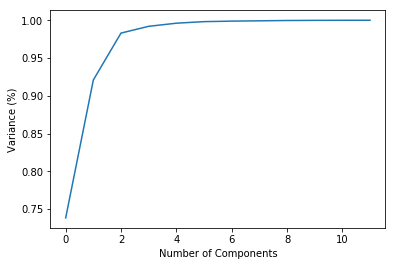

In [70]:
def plot_pca_components(df, variance = 0.9):
    X = df.loc[:, df.columns != TARGET_VARIABLE]
    y = df.loc[:, TARGET_VARIABLE]
    pca = PCA()
    X = pca.fit_transform(X)
    pca = PCA().fit(X)

    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)')
    plt.show()
    
    count = 0
    
    for ind, i in enumerate(np.cumsum(pca.explained_variance_ratio_)):
        if count < variance:
            count += i
        else:
            return ind + 1
        
plot_pca_components(data)

def perform_pca(df):
    acc, scores, model = cv_evaluate(df, transformers = PCA(.95))
    
    return acc, df

## Rebalancing
Now we will rebalance the dataset by performing undersampling based on the target variable

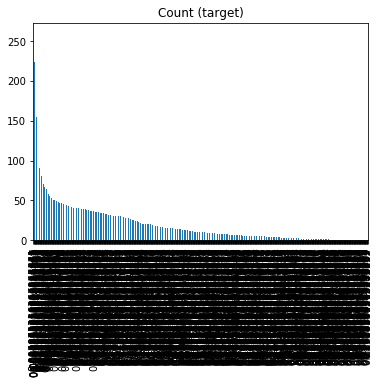

In [71]:
def target_balance(df):
    target_count = df[TARGET_VARIABLE].value_counts()
    target_count.plot(kind='bar', title='Count (target)')
    
target_balance(data)

In [72]:
def rebalance(df):
    count_class_0, count_class_1 = df[TARGET_VARIABLE].value_counts()

    df_class_0 = df[df[TARGET_VARIABLE] == 0]
    df_class_1 = df[df[TARGET_VARIABLE] == 1]
    df_class_0_under = df_class_0.sample(count_class_1)
    
    return pd.concat([df_class_0_under, df_class_1], axis=0)

# Pipeline Function
The pipeline will decide which functions to keep and which not to based on if they improve the score

In [104]:
def feature_engineering_pipeline(df, fe_functions):
    selected_functions = []
    selected_transformers = []
    
    base_score, scores, models = cv_evaluate(df)
    all_scores  = pd.DataFrame(columns = ['Function', 'CV Score', 'Holdout Score', 'Difference', 'Outcome'])
    all_scores = all_scores.append({'Function':'base_score','CV Score': '{:.2f} +/- {:.02}'.format(np.mean(scores[scores > 0.0]),np.std(scores[scores > 0.0])),'Holdout Score': base_score, 'Difference': 0, 'Outcome': 'Base'}, ignore_index=True)
    
    engineered_data = df.copy()
                                    
    for fe_function in fe_functions:
        if fe_function[0] == 'Scored':
            if len(fe_function) == 3:
                new_score, processed_data = globals()[fe_function[1]](engineered_data, fe_function[2])
            else:
                new_score, processed_data = globals()[fe_function[1]](engineered_data)
        elif fe_function[0] == 'Unscored':
            if len(fe_function) == 3:
                processed_data = globals()[fe_function[1]](engineered_data, fe_function[2])
            else:
                processed_data = globals()[fe_function[1]](engineered_data)
            new_score, scores, model = cv_evaluate(processed_data)
        else:
            new_score, scores, model = cv_evaluate(engineered_data, transformers = [fe_function[2]])

        difference = (new_score-base_score)
                                    
        if difference > 0.005:
            selected_functions.append(fe_function[1])
            if fe_function[0] == 'Transformer':
                selected_transformers.append(fe_function[2])
            else:
                engineered_data = processed_data.copy()
            base_score = new_score
            score = { 'Function':fe_function[1],'CV Score': '{:.2f} +/- {:.02}'.format(np.mean(scores[scores > 0.0]),np.std(scores[scores > 0.0])),'Holdout Score': new_score, 'Difference': difference, 'Outcome': 'Accepted'}
        else:
            score = { 'Function':fe_function[1],'CV Score': '{:.2f} +/- {:.02}'.format(np.mean(scores[scores > 0.0]),np.std(scores[scores > 0.0])),'Holdout Score': new_score, 'Difference': difference, 'Outcome': 'Rejected'}
        
        all_scores = all_scores.append(score, ignore_index=True)
            
    return selected_functions, engineered_data, all_scores, selected_transformers

# Running the Pipeline
Here we will run the pipeline

In [105]:
fe_functions = [
    ('Unscored','remove_outliers'),
#     ('Unscored','feature_selection'),
    ('Unscored','under_represented_features'), 
    ('Unscored','bin_columns', data.iloc[:,np.r_[:,6:9, 11:13]]), 
    ('Transformer','polynomial', PolynomialFeatures(degree=2, include_bias=False)),
#     ('Unscored','rebalance'),
    ('Scored','rfe'),
    ('Transformer','perform_pca', PCA(.95))
]

funcs, pipeline_data, all_scores, trans = feature_engineering_pipeline(data, fe_functions)

if len(trans) > 0:
    holdout_score, scores, model = cv_evaluate(pipeline_data, splits = SPLITS, transformers = trans)
else:
    holdout_score, scores, model = cv_evaluate(pipeline_data, splits = SPLITS)
score = { 'Function': 'cross_evaluate','CV Score': '{:.3f} +/- {:.02}'.format(np.mean(scores[scores > 0.0]),np.std(scores[scores > 0.0])), 'Holdout Score': "{0:.3f}".format(holdout_score), 'Difference': 0, 'Outcome': 'Final Cross Validation'}
all_scores = all_scores.append(score, ignore_index=True)

Removed 1036 outlier records


# Scores
Here you can see all of the scores

In [106]:
all_scores

,Function,CV Score,Holdout Score,Difference,Outcome
0,base_score,0.49 +/- 0.018,0.497004,0,Base
1,remove_outliers,0.50 +/- 0.02,0.501156,0.00415188,Rejected
2,under_represented_features,0.49 +/- 0.018,0.497004,0,Rejected
3,bin_columns,0.49 +/- 0.017,0.49591,-0.00109395,Rejected
4,polynomial,0.65 +/- 0.014,0.666116,0.169112,Accepted
5,rfe,0.65 +/- 0.014,0.34191,-0.324206,Rejected
6,perform_pca,0.48 +/- 0.016,0.486239,-0.179877,Rejected
7,cross_evaluate,0.650 +/- 0.008,0.666,0,Final Cross Validation


In [ ]:
final_model = model.best_estimator_
model.best_params_

# Final Score
This is the final score of the model